In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install beautifulsoup4 unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.4 MB/s eta 0:00:00


In [3]:
from bs4 import BeautifulSoup
import re
import unidecode

# Function to remove HTML tags and convert to lowercase
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = unidecode.unidecode(text)  # Convert Unicode characters to ASCII
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase and strip
    return text

# Main text preprocessing function
def text_preprocess(text):
    text = clean_text(text)
    # Additional steps like acronym normalization or word segmentation can be added here if needed
    return text

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming bigdata_selected is already loaded from Google Drive
# Replace this with your actual data loading code if necessary
file_path = '/content/drive/MyDrive/ABSA/bigdata_selected.csv'
bigdata_selected = pd.read_csv(file_path)

# Define features (X) and target (y)
X = bigdata_selected['Review'].astype(str).apply(text_preprocess) # Assuming 'Review' is your feature column
y = bigdata_selected[['Taste', 'Smell', 'Quality']]  # Assuming these are your target columns


split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]


# Print shapes to verify split
print("Training set:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print("Validation set:")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Now you can proceed to train your model using X_train and y_train,
# and validate using X_val and y_val


<ipython-input-3-ad48189212e9>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


Training set:
X_train shape: (2467,), y_train shape: (2467, 3)
Validation set:
X_val shape: (617,), y_val shape: (617, 3)


In [5]:
import numpy as np
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(0, len(df.columns)):
            sentiment = df.iloc[row, col]
            if   sentiment == 0: one_hot = [1, 0, 0, 0] # None
            elif sentiment == 1: one_hot = [0, 1, 0, 0] # Pos
            elif sentiment == 2: one_hot = [0, 0, 1, 0] # Neg
            elif sentiment == 3: one_hot = [0, 0, 0, 1] # Neu
            row_one_hot.extend(one_hot)

        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

In [6]:
y_train_standardize_output = make_outputs(y_train)
y_val_standardize_output = make_outputs(y_val)

print('Train outputs:', y_train_standardize_output.shape)
print('Validate outputs:', y_val_standardize_output.shape)
y_train_standardize_output[0]

Train outputs: (2467, 12)
Validate outputs: (617, 12)


array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], dtype=uint8)

<Axes: >

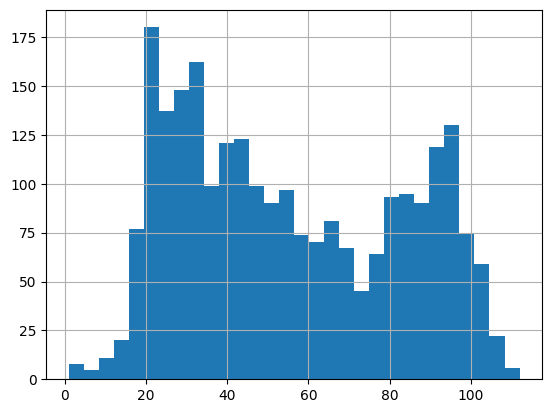

In [7]:
import pandas as pd
seq_len = [len(i.split()) for i in  X_train]
pd.Series(seq_len).hist(bins=30)

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer with OOV token
tokenizer_data = Tokenizer(oov_token="<OOV>", filters='', split=' ')
tokenizer_data.fit_on_texts(X_train)

# Convert training texts to sequences of integers
tokenizer_data_train = tokenizer_data.texts_to_sequences(X_train)
# Pad the sequences to ensure they are of the same length
vec_data_train = pad_sequences(tokenizer_data_train, maxlen=100, padding='post')

# Convert validation texts to sequences of integers
tokenizer_data_test = tokenizer_data.texts_to_sequences(X_val)
# Pad the sequences to ensure they are of the same length
vec_data_test = pad_sequences(tokenizer_data_test, maxlen=100, padding='post')

# Get the size of the vocabulary
data_vocab_size = len(tokenizer_data.word_index) + 1

# Print shapes and vocabulary size
print(vec_data_train.shape)
print(vec_data_test.shape)
print(data_vocab_size)


(2467, 100)
(617, 100)
9489


In [9]:
vec_data_train[0]

array([   3,   19,  105,  372,    8,    2, 4303,  595,  135,   53,  273,
          4,   19,  117,   24,   35,    6,   39,    8,   30,  191,    2,
         45,  582,   59,   27,    5, 2520,   51,    5, 1042,  625,    4,
          7, 1099,   82,   14, 4304,    9, 1704,    4,  120, 4305,   10,
         45,   82,   51,  157,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [10]:
print(data_vocab_size)

9489


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define your parameters
dropout_threshold = 0.4
input_dim = data_vocab_size
output_dim = 60
input_length = 100

# Initialize the Sequential model
model = Sequential()

# Add layers to the model
model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
model.add(Bidirectional(LSTM(units=output_dim, dropout=dropout_threshold, return_sequences=True),  merge_mode='concat'))
model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
model.add(GlobalAveragePooling1D())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dense(12, activation='sigmoid'))



# Compile the model
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 60)           569340    
                                                                 
 bidirectional (Bidirection  (None, 100, 120)          58080     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 120)          86880     
 onal)                                                           
                                                                 
 global_average_pooling1d (  (None, 120)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 500)               60500     
                                                        

In [13]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_lstm.h5', monitor = 'val_loss')
history= model.fit(x=vec_data_train, y =y_train_standardize_output,  epochs =10, validation_data=[vec_data_test,y_val_standardize_output], callbacks=[callback_model])


Epoch 1/10
78/78 [==============================] - 16s 153ms/step - loss: 0.4471 - binary_accuracy: 0.8107 - val_loss: 0.4117 - val_binary_accuracy: 0.8113
Epoch 2/10
 1/78 [..............................] - ETA: 8s - loss: 0.3654 - binary_accuracy: 0.8229

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 11s 139ms/step - loss: 0.3937 - binary_accuracy: 0.8228 - val_loss: 0.4162 - val_binary_accuracy: 0.7912
Epoch 3/10
78/78 [==============================] - 10s 134ms/step - loss: 0.3736 - binary_accuracy: 0.8256 - val_loss: 0.4406 - val_binary_accuracy: 0.7878
Epoch 4/10
78/78 [==============================] - 10s 131ms/step - loss: 0.3243 - binary_accuracy: 0.8515 - val_loss: 0.4851 - val_binary_accuracy: 0.7746
Epoch 5/10
78/78 [==============================] - 11s 141ms/step - loss: 0.2937 - binary_accuracy: 0.8710 - val_loss: 0.5970 - val_binary_accuracy: 0.7751
Epoch 6/10
78/78 [==============================] - 11s 137ms/step - loss: 0.2626 - binary_accuracy: 0.8840 - val_loss: 0.6020 - val_binary_accuracy: 0.7704
Epoch 7/10
78/78 [==============================] - 11s 138ms/step - loss: 0.2474 - binary_accuracy: 0.8897 - val_loss: 0.6370 - val_binary_accuracy: 0.7909
Epoch 8/10
78/78 [==============================] - 11s 138ms/step - 

In [14]:
model.save('model_final.h5')

In [15]:
from google.colab import files

In [16]:
files.download('model_lstm.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
files.download("model_final.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>